# FloraCast: Production Model Report

This notebook connects to ZenML's Model Control Plane to fetch the production model version for `floracast_tft`, load its artifacts and metrics, and visualize how the latest training and batch inference performed.

It will:
- Retrieve the production model version and list available artifacts
- Load the trained model and evaluation score
- Display training diagnostics if available
- Load the latest batch predictions (if present) or compute fresh predictions
- Recompute validation metrics locally for a sanity check and visualize forecasts


In [ ]:
# Imports and environment
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from zenml.client import Client

# Local project imports
from utils.metrics import smape
from darts import TimeSeries

# Ensure inline plotting in notebooks
try:
    from IPython import get_ipython
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

sns.set_context("talk")
sns.set_style("whitegrid")

MODEL_NAME = os.environ.get("FLORACAST_MODEL_NAME", "floracast_tft")
TARGET_STAGE = os.environ.get("FLORACAST_TARGET_STAGE", "production")
print(f"Model: {MODEL_NAME} | Stage: {TARGET_STAGE}")


Model: floracast_tft | Stage: production


In [17]:
# Connect to ZenML and resolve the production model version
client = Client()

try:
    mv = client.get_model_version(
        model_name_or_id=MODEL_NAME,
        model_version_name_or_number_or_id=TARGET_STAGE,
    )
    # Newer ZenML uses `number` instead of `version`
    mv_number = getattr(mv, "number", None)
    mv_stage = getattr(mv, "stage", None)
    print(f"Resolved production model: {mv.name} v{mv_number} (stage={mv_stage})")
except Exception as e:
    raise RuntimeError(f"Could not resolve production model for {MODEL_NAME}@{TARGET_STAGE}: {e}")

Resolved production model: 9 v9 (stage=production)


In [18]:
# Try to load trained model and evaluation score
trained_model = None
eval_score = None


try:
    trained_model = mv.get_artifact("trained_model").load()
    print(f"Loaded trained model: {type(trained_model).__name__}")
except Exception as e:
    print("Failed to load trained model:", e)

try:
    eval_score = float(mv.get_artifact("evaluation_score").load())
    print(f"Production evaluation score (smape): {eval_score:.3f}")
except Exception as e:
    print("Failed to load evaluation score:", e)


Loading TFT model with PyTorch state reconstruction
Reconstructing internal PyTorch model
Train dataset contains 14 samples.
Time series values are 64-bits; casting model to float64.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/htahir1/workspace/zenml_io/zenml-projects/floracast/materializers/tft_materializer.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(temp_f

Trainer.fit stopped: max_epochs=1 reached.
Loaded trained model: TFTModel
Production evaluation score (smape): 167.418


In [19]:
# Load dataset for context and to recompute validation metrics if needed
# Standalone version to avoid running ZenML steps in the notebook
from steps.ingest import generate_ecommerce_data
from darts import TimeSeries

csv_path = os.path.join(os.path.dirname(__file__) if "__file__" in globals() else os.getcwd(), "data", "ecommerce_daily.csv")
if os.path.exists(csv_path):
    raw_df = pd.read_csv(csv_path, parse_dates=["ds"]).sort_values("ds").reset_index(drop=True)
    print(f"Loaded dataset from {csv_path} ({len(raw_df)} rows)")
else:
    raw_df = generate_ecommerce_data()
    print(f"Generated synthetic dataset ({len(raw_df)} rows)")

# Create TimeSeries and split
series = TimeSeries.from_dataframe(raw_df, time_col="ds", value_cols="y", freq="D")
split_idx = int(len(series) * 0.8)
train_series = series[:split_idx]
val_series = series[split_idx:]
full_series = series

print(f"Train points: {len(train_series)}, Val points: {len(val_series)}, Full series: {len(full_series)}")


Loaded dataset from /home/htahir1/workspace/zenml_io/zenml-projects/floracast/data/ecommerce_daily.csv (240 rows)
Train points: 192, Val points: 48, Full series: 240


In [20]:
# Visualize training loss (if saved by materializer) and metadata (no PIL required)
from IPython.display import Image as IPyImage, display
from zenml.io import fileio

# If you want to visualize files from the trained_model artifact (if available)
found_any = False
if trained_model is not None and hasattr(trained_model, "artifact_uri"):
    for fname in ["training_loss.png", "preview.png"]:
        uri = os.path.join(trained_model.artifact_uri, fname)
        try:
            if fileio.exists(uri):
                with fileio.open(uri, "rb") as f:
                    data = f.read()
                print(f"trained_model: {fname}")
                display(IPyImage(data=data))
                found_any = True
        except Exception:
            pass

if not found_any:
    print("No saved visualizations found for the trained model.")


No saved visualizations found for the trained model.


In [21]:
# Load latest batch predictions artifact if present; else compute fresh predictions
pred_df = None
try:
    pred_df = mv.get_artifact("predictions").load()
    if isinstance(pred_df, pd.DataFrame):
        print(f"Loaded predictions artifact with {len(pred_df)} rows")
    else:
        pred_df = None
except Exception as e:
    print("Failed to load predictions artifact:", e)

if pred_df is None and trained_model is not None:
    try:
        horizon = 14
        preds = trained_model.predict(n=horizon, series=full_series)
        pred_df = preds.pd_dataframe().reset_index()
        pred_df.columns = ["ds", "yhat"]
        print(f"Computed fresh predictions: {len(pred_df)} rows")
    except Exception as e:
        print("Failed to compute fresh predictions:", e)

pred_df.head(5) if pred_df is not None else None


Loaded predictions artifact with 14 rows


,ds,yhat
0,2025-10-18 12:03:14,13.236199
1,2025-10-19 12:03:14,11.992016
2,2025-10-20 12:03:14,12.137806
3,2025-10-21 12:03:14,10.914396
4,2025-10-22 12:03:14,11.435117


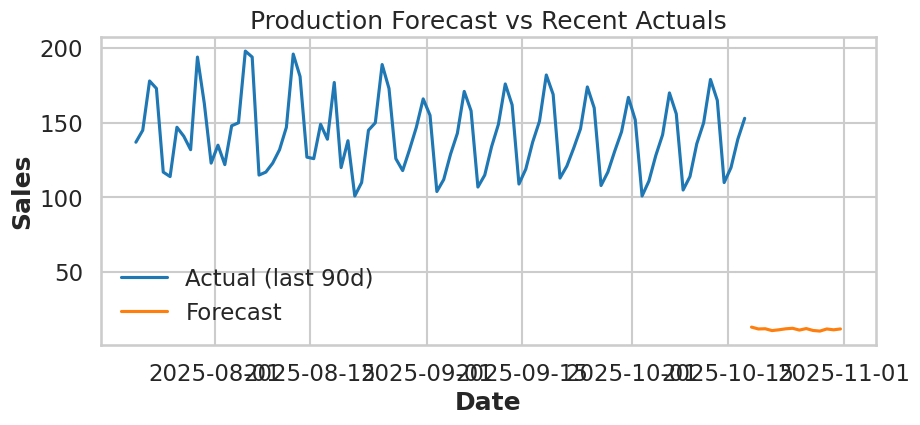

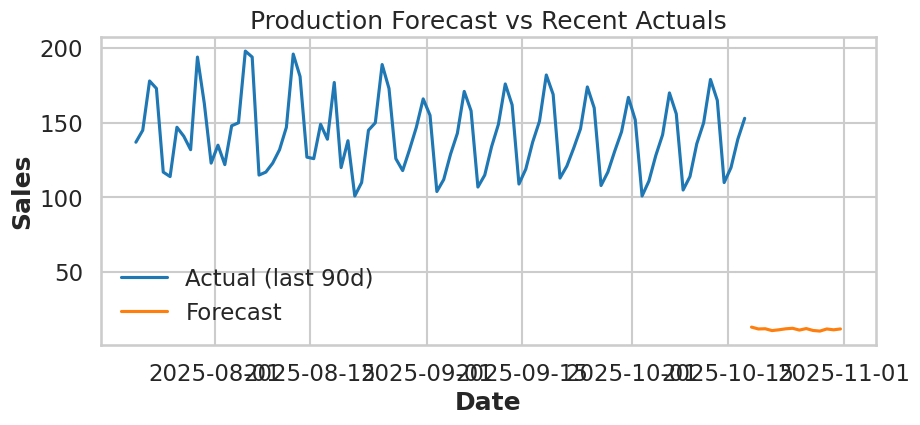

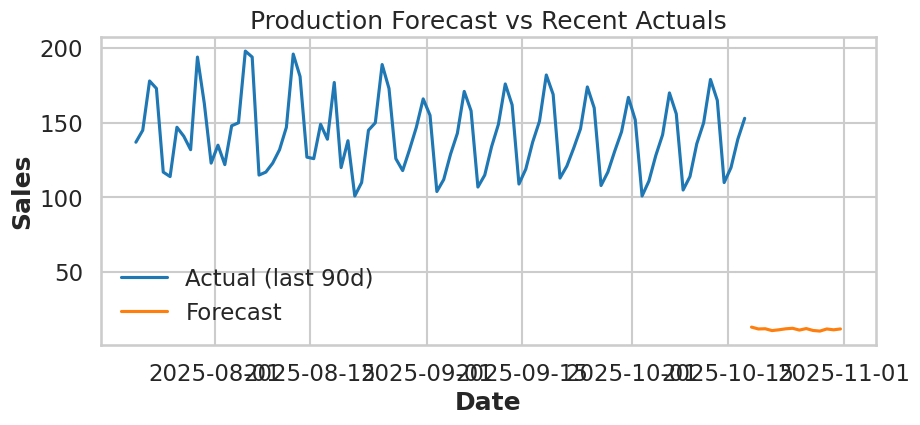

<module 'matplotlib.pyplot' from '/home/htahir1/.virtualenvs/floracast/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [22]:
# Plot predictions against the tail of the actual series

fig, ax = plt.subplots(figsize=(10, 4))
# Actual history (last 90 days)
hist = raw_df.tail(90)
ax.plot(hist["ds"], hist["y"], label="Actual (last 90d)", color="#1f77b4")
ax.plot(pred_df["ds"], pred_df["yhat"], label="Forecast", color="#ff7f0e")
ax.set_title("Production Forecast vs Recent Actuals")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
plt.show()
plt

In [15]:
# Recompute evaluation metric on validation split for sanity check
recomputed_smape = None
if trained_model is not None and len(val_series) > 0:
    try:
        horizon = min(7, len(val_series))
        pred_val = trained_model.predict(n=horizon, series=train_series)
        actual_val = val_series[: len(pred_val)]
        recomputed_smape = smape(actual_val, pred_val)
        print(f"Recomputed sMAPE on val split: {recomputed_smape:.3f}")
    except Exception as e:
        print("Failed to recompute validation sMAPE:", e)

if recomputed_smape is not None and eval_score is not None:
    print(f"Production stored sMAPE: {eval_score:.3f} | Recomputed: {recomputed_smape:.3f}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Recomputed sMAPE on val split: 167.641
Production stored sMAPE: 167.418 | Recomputed: 167.641


## Notes
- You can set `FLORACAST_MODEL_NAME` and `FLORACAST_TARGET_STAGE` environment variables to switch model/stage.
- If artifacts like `trained_model` or `predictions` are missing, the notebook will gracefully continue and try to recompute where possible.
- Visualizations are pulled directly from artifact URIs when present.


In [24]:
# Summary table of key metrics
rows = []
if eval_score is not None:
    rows.append({"metric": "stored_smape", "value": eval_score})
if 'recomputed_smape' in globals() and recomputed_smape is not None:
    rows.append({"metric": "recomputed_smape", "value": recomputed_smape})
if pred_df is not None:
    rows.append({"metric": "predictions_rows", "value": len(pred_df)})

summary_df = pd.DataFrame(rows)
summary_df if not summary_df.empty else pd.DataFrame([{"note": "No metrics available yet."}])


,metric,value
0,stored_smape,167.417932
1,recomputed_smape,167.640742
2,predictions_rows,14.000000
